In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any, List
from opik import Opik
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches


SENTENCE_TRANSFORMER_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

OPIK_RESPONSE_GENERATION_PROJECT_NAME = "LLMmark_response_generation"

EMPTY_PLACEHOLDER = '_EMPTY_FAILURE_'
TIMEOUT_PLACEHOLDER = '_TIMEOUT_FAILURE_'
OVERTHINK_PLACEHOLDER = '_OVERTHINK_FAILURE_'


/home/cim/LLMmark/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def preprocess_and_identify_failures(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies failed responses in the DataFrame based on timeout or token limit.
    """
    timeout = 120
    
    is_empty = df['span_output_raw_answer'].fillna('').str.strip() == ''
    
    # It is considered timeout if the response time is > 120 seconds and the answer is empty
    # Some models like gemma3n can take more than 120 seconds because of the memory limit (we use swap memory)
    is_timeout = (df['response_time'] >= timeout).fillna(False) & is_empty
    
    
    # If the raw_answer contains <think>, we consider that it has reached the token limit or an infinite loop
    is_token_limit_hit = df['span_output_raw_answer'].str.contains('<think>', na=False)
    
    df['is_failure'] = is_timeout | is_token_limit_hit | is_empty
    
    conditions = [
        is_timeout,
        is_token_limit_hit,
        is_empty
    ]
    
    placeholders = [
        TIMEOUT_PLACEHOLDER,
        OVERTHINK_PLACEHOLDER,
        EMPTY_PLACEHOLDER
    ]
    
    # Apply the failure placeholders in the answer column, else keep the original raw answer
    df['answer'] = np.select(conditions, placeholders, default=df['span_output_raw_answer'])

    failure_count = df['is_failure'].sum()
    if failure_count > 0:
        print(f"INFO: Total of {failure_count} failed responses (timeout, empty answer or infinite loop).")

    return df


def parse_model_info(model_name: str, tags: List[str]) -> Dict[str, str]:
    """
    Parses model ID, display name, and size from the model name and tags.
    Adjust this function based on your actual model naming conventions.
    """
    model_id = model_name
    model_size = "N/A"
    question_type = "N/A"

    match = re.search(r':([\d\.]+)b', model_name)
    if match:
        model_size = match.group(1) + "B"

    if "multiple_choice" in tags:
        question_type = "multiple_choice"
    elif "open_answer" in tags:
        question_type = "open_answer"

    return {
        "model_id": model_id,
        "model_size": model_size,
        "question_type": question_type
    }

def get_opik_flat_data_for_csv(project_name: str = OPIK_RESPONSE_GENERATION_PROJECT_NAME) -> List[Dict[str, Any]]:
    """
    Fetches detailed trace and span data from Opik and flattens it for CSV export.
    Each dictionary in the returned list represents a single span,
    including its parent trace's metadata.
    """
    client = Opik()
    flat_data = []

    print(f"Fetching traces from project: {project_name}...")

    traces = client.search_traces(
        project_name=project_name,
        max_results=100000,
    )

    if not traces:
        print(f"No traces found in project '{project_name}'. Please check the project name and your Opik configuration.")
        return []
    
    # Delete traces with None values
    traces = [trace for trace in traces if trace.name is not None]

    for i, trace in enumerate(traces):
        
        print(f"Processing trace {i+1}/{len(traces)}: {trace.name} ({trace.id})")

        trace_content = client.get_trace_content(trace.id)
        spans = client.search_spans(project_name=project_name, trace_id=trace.id)

        if not spans:
            print(f"  No spans found for trace {trace.id}. Skipping.")
            continue

        model_info = parse_model_info(trace.name, trace.tags)
        
        model_source = "N/A"
        if "local" in trace.tags:
            model_source = "local"
        elif "online" in trace.tags:
            model_source = "online"

        trace_flat_metadata = {
            "trace_id": trace.id,
            "run_name": trace.name,
            "model_display_name": trace_content.metadata.get("model_display_name"),
            "language": trace_content.metadata.get("language", "en"),
            "prompting_tech": trace_content.metadata.get("prompting_tech", "N/A"),
            "num_runs_per_question": trace_content.metadata.get("num_runs_per_question", 1),
            "model_source": model_source,
            "temperature": trace_content.metadata.get("temperature", "N/A"),
            "top_p": trace_content.metadata.get("top_p", 0.1),
            "exercise": trace_content.metadata.get("exercise", "N/A"),
            "question_type": model_info["question_type"],
            **{f"trace_meta_{k.replace('.', '_')}": v for k, v in trace_content.metadata.items()
            if k not in ["language", "prompting_tech", "num_runs_per_question", 
                         "model_source", "temperature", "top_p", "exercise", 
                         "prompt_tech", "question_type", "comments", "model_id", "model_display_name", "top-p", "run_name"]}
        }

        # Process each span and combine with trace-level metadata
        for j, span in enumerate(spans):
            span_response_time = span.output.get("response_time (s)", "N/A")

            span_input_question = span.input.get("question", str(span.input)) if isinstance(span.input, dict) else str(span.input)
            span_output_answer = span.output.get("answer", str(span.output)) if isinstance(span.output, dict) else str(span.output)
            span_output_raw_answer = span.output.get("raw_answer", span_output_answer) if isinstance(span.output, dict) else span_output_answer

            correct_answer = span.metadata.get("correct_answer", "PLACEHOLDER_CORRECT_ANSWER")
            
            
            span_usage = span.usage or {}
            completion_tokens = span_usage.get("completion_tokens", 0)

            span_data_row = {
                "span_id": span.id,
                "span_name": span.name,
                "response_time": span_response_time,
                "span_input_question": span_input_question,
                "span_output_answer": span_output_answer,
                "span_output_raw_answer": span_output_raw_answer,
                "span_correct_answer": correct_answer,
                "completion_tokens": completion_tokens,
                "question_file": span.metadata.get("question_file", "N/A"),
            }
            
            combined_row = {**span_data_row, **trace_flat_metadata}
            flat_data.append(combined_row)

    return flat_data


def get_dataframe_from_csv(csv_filename: str = "opik_determinism_data.csv") -> pd.DataFrame:
    """Reads a CSV file into a DataFrame.

    Args:
        csv_filename (str, optional): The name of the CSV file to read. Defaults to "opik_determinism_data.csv".

    Returns:
        pd.DataFrame: The DataFrame containing the CSV data.
    """
    output_dir = '../../../data/response_generation'
    output_path = os.path.join(output_dir, csv_filename)
    
    if not os.path.exists(output_path):
        print(f"CSV file {output_path} does not exist.")
        return pd.DataFrame()
    
    df = pd.read_csv(output_path, encoding='utf-8')
    print(f"DataFrame loaded from {output_path} with shape: {df.shape}")
    
    return df


def filter_and_save_dataframe(
    df: pd.DataFrame, 
    csv_filename: str = "opik_response_generation.csv"
) -> None:
    """Filters the DataFrame by temperature and saves it to a CSV file.

    Args:
        df (pd.DataFrame): The DataFrame to filter.
        csv_filename (str, optional): The name of the CSV file to save. Defaults to "opik_response_generation.csv".
    """
    if df.empty:
        print("\nInput DataFrame is empty. No CSV file will be created.")
        return

    filtered_df = df.copy()


    output_filename = csv_filename
    output_dir = '../../../data/response_generation'
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_filename)
    
    filtered_df.to_csv(output_path, index=False, encoding='utf-8')

    print(f"\nSuccessfully extracted data and saved to {output_path}")
   

def plot_response_time_by_model(df: pd.DataFrame):
    """
    Generates a bar plot of average response time by model, coloring the bars based on execution type and adding a legend.

    Args:
        df (pd.DataFrame): The DataFrame containing response time data.

    Returns:
        None
    """
    df_successful = df[df['is_failure'] == False].copy()

    df_successful['response_time'] = pd.to_numeric(df_successful['response_time'], errors='coerce')
    df_successful.dropna(subset=['response_time'], inplace=True)

    avg_response_time = df_successful.groupby('model_display_name')['response_time'].mean().sort_values()

    avg_response_time_df = avg_response_time.reset_index()
    avg_response_time_df.rename(columns={'model_display_name': 'Modelo', 'response_time': 'Tiempo de Respuesta (segundos)'}, inplace=True)

    def get_execution_type(model_name):
        if 'gemini' in model_name.lower():
            return 'Ejecución en la Nube'
        elif 'gemma3n' in model_name.lower():
            return 'Ejecución con Swap'
        else:
            return 'Ejecución Local'

    avg_response_time_df['execution_type'] = avg_response_time_df['Modelo'].apply(get_execution_type)

    palette = {
        'Ejecución en la Nube': "#231726",
        'Ejecución con Swap':   '#cb4955',
        'Ejecución Local':      "#A8D6CB",
    }

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))

    ax = sns.barplot(
        x='Modelo',
        y='Tiempo de Respuesta (segundos)',
        data=avg_response_time_df,
        palette=palette,
        hue='execution_type',
        dodge=False
    )

    ax.set_title('Tiempo de Respuesta Promedio por Modelo (Ejecuciones Exitosas)', fontsize=16)
    ax.set_xlabel('Modelo', fontsize=12)
    ax.set_ylabel('Tiempo de Respuesta (segundos)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Tipo de Ejecución', fontsize=10)

    plt.tight_layout()
    plt.show()



In [4]:
# Get all the data of Opik determinism project
all_opik_data = get_opik_flat_data_for_csv()


Fetching traces from project: LLMmark_response_generation...
Processing trace 1/1032: run_1075_gemma3n:e4b (0197e957-0575-786e-9546-344e99614336)
Processing trace 2/1032: run_1072_smollm2:1.7b (0197e94e-89b5-7150-82ff-1dedb9efb115)
Processing trace 3/1032: run_1070_qwen3:4b (0197e93a-3edd-7b4e-b051-34648691b695)
Processing trace 4/1032: run_1068_qwen3:1.7b (0197e929-46c0-778d-82c3-54323e968375)
Processing trace 5/1032: run_1066_gemma3n:e4b (0197e90f-a4e1-7c38-ba68-84b4eb56b4e0)
Processing trace 6/1032: run_1063_smollm2:1.7b (0197e90d-353d-7456-aa32-fd03eb223052)
Processing trace 7/1032: run_1061_qwen3:4b (0197e8f4-40b0-70a2-a220-0becce2c5730)
Processing trace 8/1032: run_1059_qwen3:1.7b (0197e8e6-454c-7e6e-a412-a24cccb1ec23)
Processing trace 9/1032: run_1057_gemma3n:e4b (0197e8c8-e5ea-756a-aed1-6a7d94c96e20)
Processing trace 10/1032: run_1054_smollm2:1.7b (0197e8c3-26d1-7dfb-8496-04e5717443da)
Processing trace 11/1032: run_1052_qwen3:4b (0197e8ad-0740-7cc8-be70-6cede5fe8643)
Processing

In [5]:

# Get all the info from Opik (traces and spans) and create a DataFrame and CSV file for each temperature
if all_opik_data:
    full_df = pd.DataFrame(all_opik_data).copy()
    print(f"\nFull DataFrame loaded with shape: {full_df.shape}")
    
    full_df = preprocess_and_identify_failures(full_df)
    
    # Save full dataframe
    filter_and_save_dataframe(full_df)

else:
    print("No data fetched from Opik to create any CSV files.")


Full DataFrame loaded with shape: (11440, 20)
INFO: Total of 541 failed responses (timeout, empty answer or infinite loop).

Successfully extracted data and saved to ../../../data/response_generation/opik_response_generation.csv


In [ ]:
csv_filename="opik_response_generation.csv"
gen_responses_df = get_dataframe_from_csv(csv_filename=csv_filename)
df = gen_responses_df.copy()
# df.head()

DataFrame loaded from ../../../data/response_generation/opik_response_generation.csv with shape: (11440, 22)


,span_id,span_name,response_time,span_input_question,span_output_answer,span_output_raw_answer,span_correct_answer,completion_tokens,question_file,trace_id,...,language,prompting_tech,num_runs_per_question,model_source,temperature,top_p,exercise,question_type,is_failure,answer
0,0197e974-1e71-739b-9115-bcd7e52df66e,q10_r1,200.103,¿Cuál es la suma de los números binarios 11100...,NaN,NaN,1101000101,0,question_10.txt,0197e957-0575-786e-9546-344e99614336,...,es,D4,1,local,0.0,0.1,exam_01_oa,open_answer,True,_TIMEOUT_FAILURE_
1,0197e971-0fb5-712e-bcce-bbb381c6e89f,q9_r1,200.101,¿Cuál es la suma de los números binarios 01000...,NaN,NaN,01010101,0,question_09.txt,0197e957-0575-786e-9546-344e99614336,...,es,D4,1,local,0.0,0.1,exam_01_oa,open_answer,True,_TIMEOUT_FAILURE_
2,0197e96e-00c1-702e-9676-324c6ad029f4,q8_r1,200.101,¿Cuál es la representación del número decimal ...,NaN,NaN,1110.011,0,question_08.txt,0197e957-0575-786e-9546-344e99614336,...,es,D4,1,local,0.0,0.1,exam_01_oa,open_answer,True,_TIMEOUT_FAILURE_
3,0197e96a-eefd-74d3-bef6-11c9b9609a91,q7_r1,199.513,¿Cuál es la representación del número binario ...,¡Excelente pregunta! Vamos a desglosarla paso ...,¡Excelente pregunta! Vamos a desglosarla paso ...,0.703125,0,question_07.txt,0197e957-0575-786e-9546-344e99614336,...,es,D4,1,local,0.0,0.1,exam_01_oa,open_answer,False,¡Excelente pregunta! Vamos a desglosarla paso ...
4,0197e967-e218-73ba-b022-1e58a4fe65b1,q6_r1,199.886,¿Cuál es la representación del número decimal ...,¡Excelente pregunta! Vamos a desglosarla paso ...,¡Excelente pregunta! Vamos a desglosarla paso ...,0.1101,0,question_06.txt,0197e957-0575-786e-9546-344e99614336,...,es,D4,1,local,0.0,0.1,exam_01_oa,open_answer,False,¡Excelente pregunta! Vamos a desglosarla paso ...


Successfully loaded the dataset.


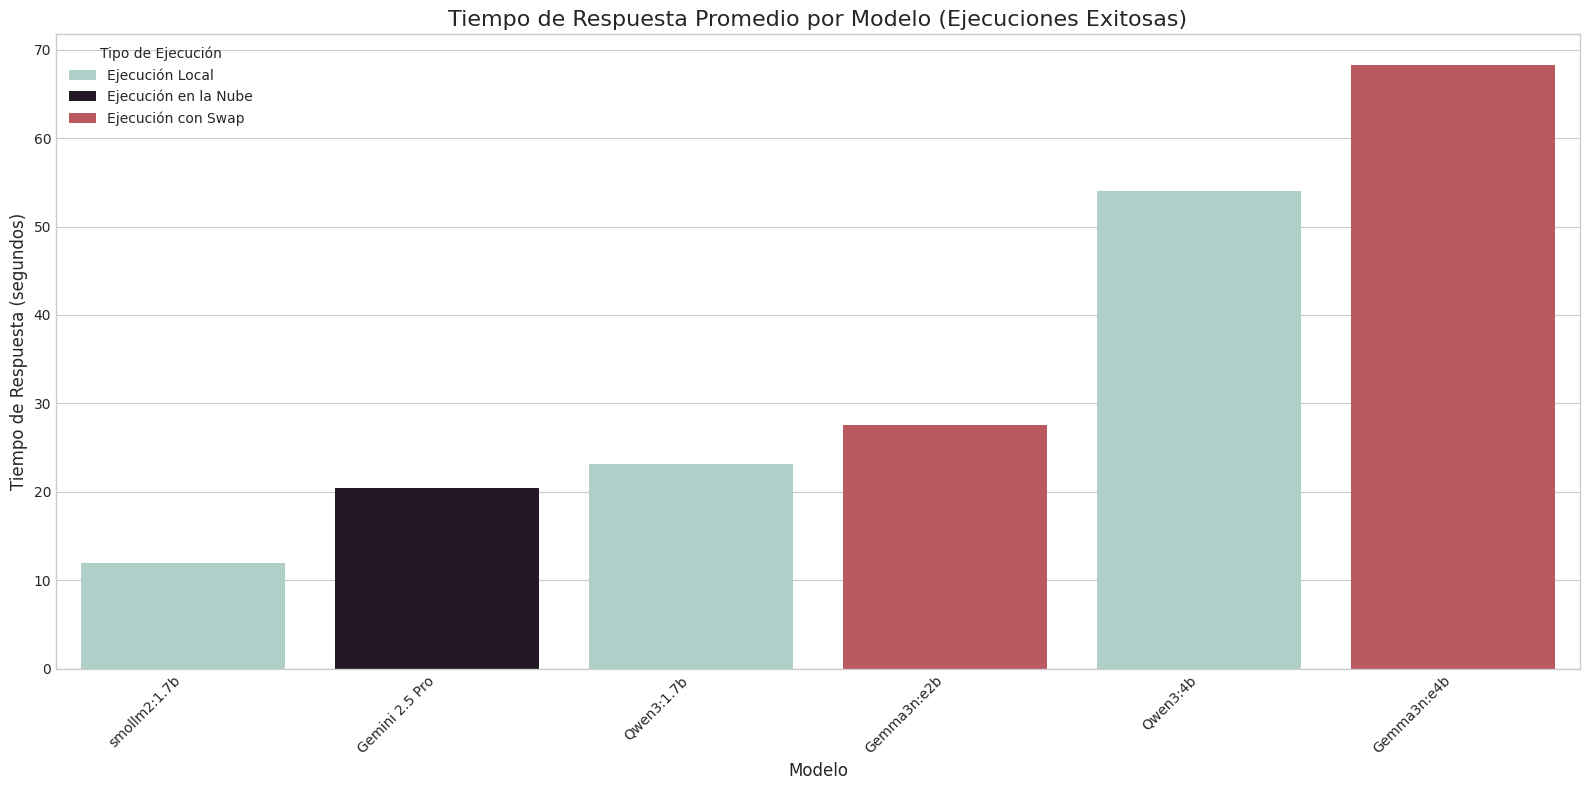

In [ ]:
try:
    df = pd.read_csv('../../../data/response_generation/opik_response_generation.csv')
    print("Successfully loaded the dataset.")
except FileNotFoundError:
    print("Error: The CSV file was not found. Please ensure the previous cells have been run successfully.")
    df = pd.DataFrame()




if not df.empty:
    df['response_time'] = pd.to_numeric(df['response_time'], errors='coerce')
    df.dropna(subset=['response_time'], inplace=True)
    successful_runs_df = df[df['is_failure'] == False].copy()

    plot_response_time_by_model(successful_runs_df)


/tmp/ipykernel_109874/1077497021.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_109874/1077497021.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


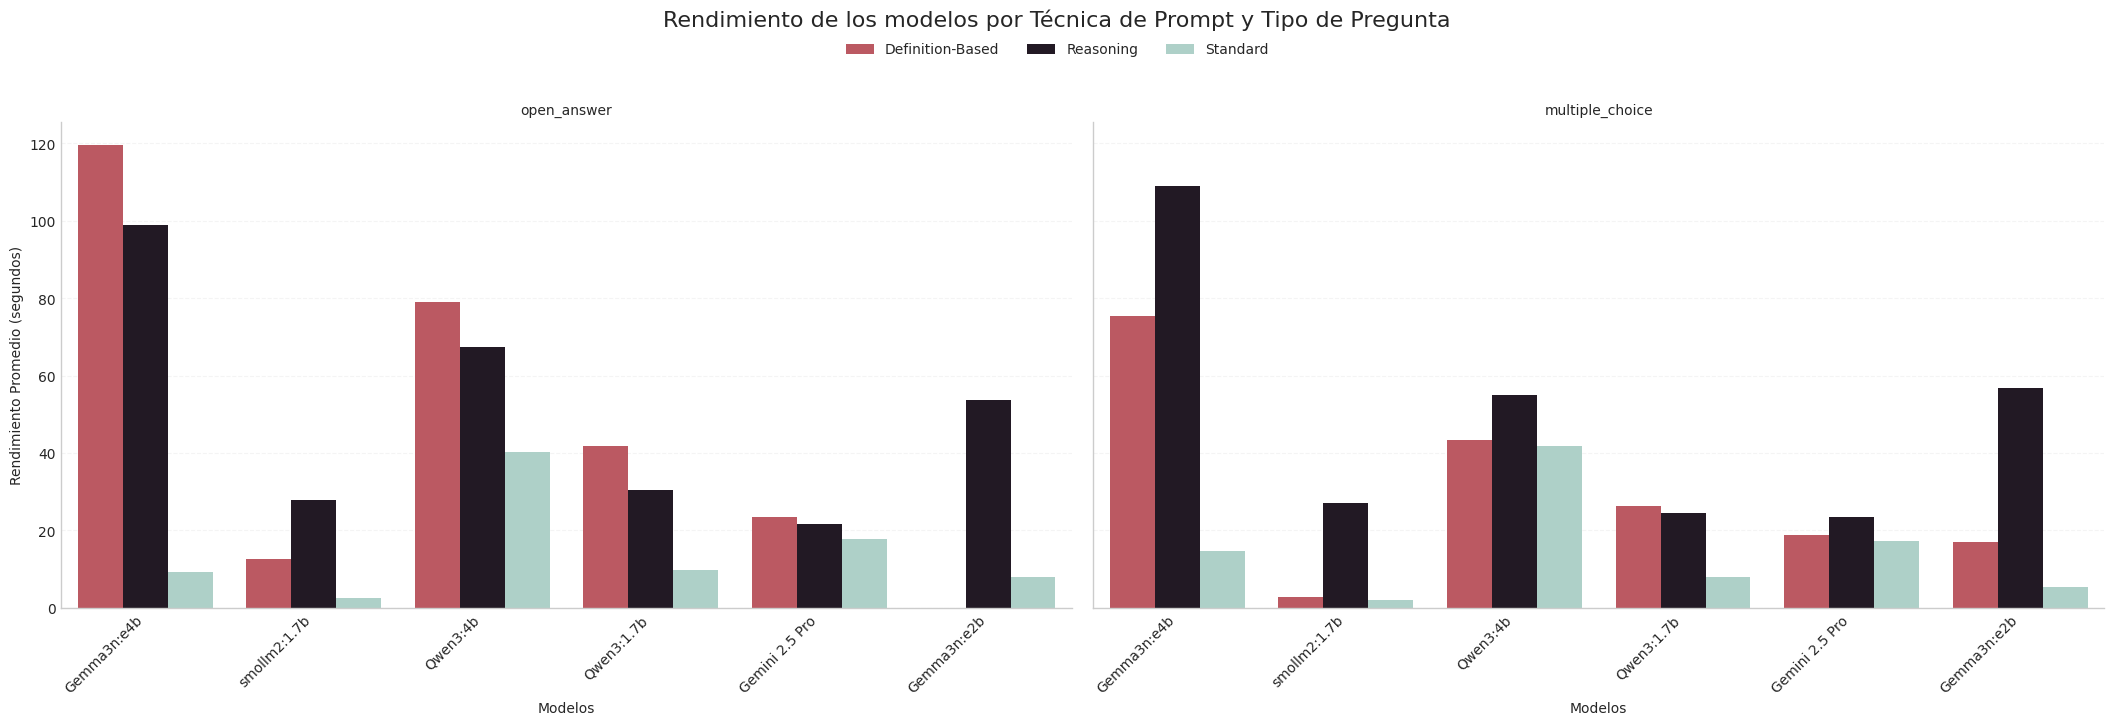

In [ ]:
try:
    df = pd.read_csv('../../../data/response_generation/opik_response_generation.csv')
except FileNotFoundError:
    print("Error: The CSV file was not found. Please ensure the initial data generation script has run.")
    df = pd.DataFrame()

if not df.empty:
    df['response_time'] = pd.to_numeric(df['response_time'], errors='coerce')
    df.dropna(subset=['response_time'], inplace=True)
    
    successful_runs_df = df[(df['is_failure'] == False) & (df['response_time'] > 0)].copy()

    unique_prompts = successful_runs_df['prompting_tech'].unique()

    prompt_category_map = {
        'S1': 'Standard', 'S2': 'Standard', 'S3': 'Standard', 'S4': 'Standard',
        'R1': 'Reasoning', 'R2': 'Reasoning', 'R3': 'Reasoning', 'R4': 'Reasoning',
        'D1': 'Definition-Based', 'D2': 'Definition-Based', 'D3': 'Definition-Based', 'D4': 'Definition-Based'
    }
    successful_runs_df['prompt_category'] = successful_runs_df['prompting_tech'].map(prompt_category_map)

    
    successful_runs_df.dropna(subset=['prompt_category'], inplace=True)

    if successful_runs_df.empty:
        print("\n Error: The DataFrame is empty after processing. Cannot generate plot.")
    else:
        g = sns.catplot(
            data=successful_runs_df,
            x='model_display_name',
            y='response_time',
            hue='prompt_category',
            col='question_type',
            kind='bar',
            height=7,
            aspect=1.4,
            palette= {
                "#231726",
                '#cb4955',
                "#A8D6CB",
            },
            errorbar=None
        )

        g.set_axis_labels("Modelos", "Rendimiento Promedio (segundos)")
        g.set_titles("{col_name}")
        g.fig.suptitle('Rendimiento de los modelos por Técnica de Prompt y Tipo de Pregunta', y=1.03, fontsize=16)

        sns.move_legend(
            g,
            "upper center",
            bbox_to_anchor=(.5, 1.0),
            ncol=3,
            title=None,
            frameon=False
        )
        
        for ax in g.axes.flat:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.grid(axis='y', linestyle='--', alpha=0.2)
            ax.yaxis.set_major_locator(mticker.MultipleLocator(20))

            
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()